In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import torchvision.models as models
from transformers import get_cosine_schedule_with_warmup
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
use_cuda = True
# 这里的扰动量先设定为几个值，后面可视化展示不同的扰动量影响以及成像效果
epsilons = [0, .05, .1, .15, .2, .25, .3,.35,.4]

# 设置训练次数
epoch = 10

transform = transforms.Compose([
            transforms.ToTensor()
            , transforms.RandomCrop(32, padding=4)  # 先四周填充0，在吧图像随机裁剪成32*32
            , transforms.RandomHorizontalFlip(p=0.5)  # 随机水平翻转 选择一个概率概率
            , transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 均值，标准差
        ])

# 运行需要稍等，这里表示下载并加载数据集
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=512, shuffle=True)

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=512, shuffle=True)
# 看看我们有没有配置GPU，没有就是使用cpu
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
ResNet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
ResNet.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
ResNet.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False) 
ResNet.conv1.maxpool = nn.MaxPool2d(1, 1, 0)
# 实例化模型并移动到GPU
model = ResNet.to(device)
pretrained_model = "../data/model.pth"
model.load_state_dict(torch.load(pretrained_model))
#指定损失函数、优化器、学习率衰减
cross_entropy_loss = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=epoch*len(test_loader))
#定义训练函数
def train(model, device, train_loader, optimizer, epoch):
    model.train() 
    for batch_idx, (data, label) in enumerate(train_loader): 
        data, label = data.to(device), label.to(device)
        output = model(data)
        loss = cross_entropy_loss(output, label)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        #if (batch_idx + 1) % 20 == 0: 
            #writer.add_scalar(tag="loss", scalar_value=loss, global_step=batch_idx)
        if (batch_idx + 1) % 10 == 0:
            print('正在训练的Epoch: {} [{}/{} ({:.0f}%)]\t损失: {:.4f}'.format(epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),100. * (batch_idx + 1) / len(train_loader), loss.item()))
        # 保存模型
        torch.save(model.state_dict(),'../data/model.pth')
# 开始训练
# for i in range(epoch):train(model, device, train_loader, optimizer, i) 
# pretrained_model = "../data/model.pth"
# print(pretrained_model)
model.load_state_dict(torch.load(pretrained_model))
# 设置为验证模式. 
model.eval()

Files already downloaded and verified
Files already downloaded and verified
CUDA Available:  True


ResNet(
  (conv1): Conv2d(
    3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [2]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # 使用sign（符号）函数，将对x求了偏导的梯度进行符号化
    sign_data_grad = data_grad.sign()
    # 通过epsilon生成对抗样本
    perturbed_image = image + epsilon*sign_data_grad
    # 做一个剪裁的工作，将torch.clamp内部大于1的数值变为1，小于0的数值等于0，防止image越界
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回对抗样本
    return perturbed_image

In [3]:
def test( model, device, test_loader, epsilon ):

    # 准确度计数器
    correct = 0
    # 对抗样本
    adv_examples = []
    ini_examples = []

    # 循环所有测试集
    for data, target in test_loader:
        # 将数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        # 设置张量的requires_grad属性。重要的攻击
        data.requires_grad = True

        # 通过模型向前传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 得到最大对数概率的索引

        # 如果最初的预测是错误的，不要再攻击了，继续下一个目标的对抗训练
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 使所有现有的梯度归零
        model.zero_grad()

        # 计算模型的后向梯度
        loss.backward()

        # 收集datagrad
        data_grad = data.grad.data

        # 调用FGSM攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 对受扰动的图像进行重新分类
        output = model(perturbed_data)

        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1] # 得到最大对数概率的索引
        if final_pred.item() == target.item():
            correct += 1
            # 这里都是为后面的可视化做准备
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 这里都是为后面的可视化做准备
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算最终精度
    final_acc = correct/float(len(test_loader))
    print("扰动量: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回准确性和对抗性示例
    return final_acc, adv_examples, ini_examples

Files already downloaded and verified
扰动量: 0	Test Accuracy = 7750 / 10000 = 0.775
扰动量: 0.05	Test Accuracy = 2429 / 10000 = 0.2429
扰动量: 0.1	Test Accuracy = 1918 / 10000 = 0.1918
扰动量: 0.15	Test Accuracy = 1425 / 10000 = 0.1425
扰动量: 0.2	Test Accuracy = 1233 / 10000 = 0.1233
扰动量: 0.25	Test Accuracy = 1200 / 10000 = 0.12
扰动量: 0.3	Test Accuracy = 1213 / 10000 = 0.1213
扰动量: 0.35	Test Accuracy = 1226 / 10000 = 0.1226
扰动量: 0.4	Test Accuracy = 1190 / 10000 = 0.119


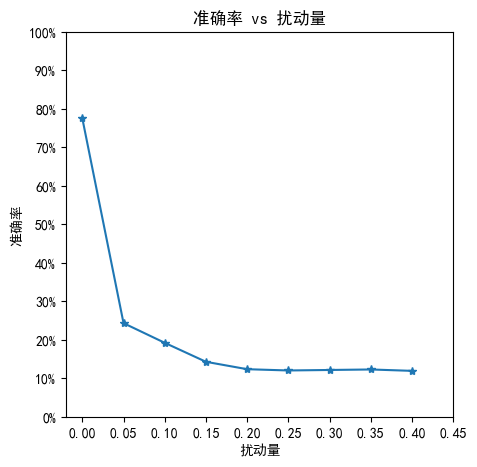

In [4]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

accuracies = []
examples = []

# 对每个干扰程度进行测试
for eps in epsilons:
    acc, ex, iex= test(model, device, test_loader, eps)
    accuracies.append(acc*100)
    examples.append(ex)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 110, step=10))
plt.xticks(np.arange(0, .5, step=0.05))
def to_percent(temp, position):
    return '%1.0f'%(temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.title("准确率 vs 扰动量")
plt.xlabel("扰动量")
plt.ylabel("准确率")
plt.show()

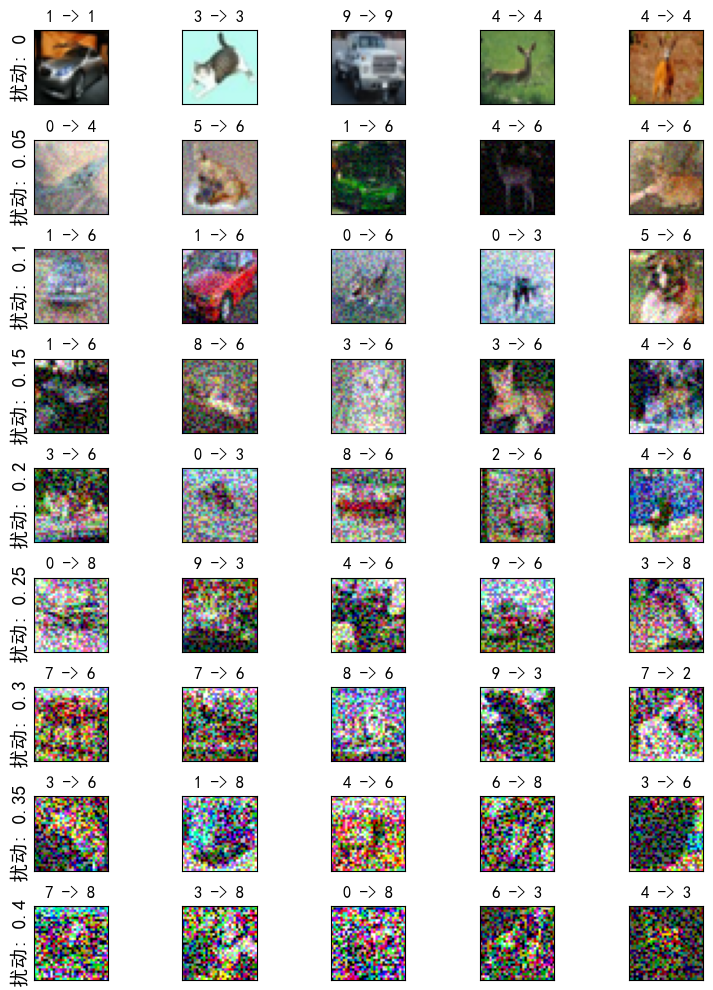

In [ ]:
# 在每个处绘制几个对抗性样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("扰动: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex=ex.reshape(3,32,32)
        ex=ex.transpose(1,2,0)

        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()